In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import rel_entr

In [11]:
plt.style.use('matplot.mplstyle')

In [12]:
def get_data(model_name, nctxt, mode, n, ubs, regime, context_style, dataset_name, M=10, lr='1e-05'):
    dflist = []
    be = 0
    for i in range(M):
        if mode == 'icl':
            dfa = pd.read_csv(f'nctxt{nctxt}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs1_uepochs1_bs{ubs}_{context_style}_nctxt{nctxt}_{regime}.csv', index_col=False)
        else:
            dfa = pd.read_csv(f'bs{ubs}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs1_uepochs1_bs{ubs}_lr{lr}.csv', index_col=False)
        for t in ['train', 'test', 'forget']:
            dfa[f'labels_{t}_{be}'] = dfa[f'labels_{t}_{be}'].replace({'tensor(0)': 'negative',
                                                                       'tensor(1)': 'positive'})
        
        dflist.append(dfa)
    # ind_mask_all = pd.read_csv(f"nctxt{nctxt}/{dataset_name}_mask_epochs1_unlearnbs{ubs}.csv", index_col=False).to_numpy()
    # ind_mask_all_extended = pd.read_csv(f"nctxt{nctxt}/{dataset_name}_extendedmask_epochs1_unlearnbs{ubs}.csv", index_col=False).to_numpy()
    return dflist

In [13]:
def get_accuray(df, method, t, b):
    predname = f"{method}_{t}_{b}"
    labelname = f"{t}_{b}"
    acc =(df[f'labels_{labelname}'] == df[f'nxt_token_preds_{predname}']).sum()/df.shape[0]
    return acc

def get_accs(df, bs, methods=['icl', 'ga', 'base'], ts=['forget', 'test', 'train']):
    names = []
    accs = []
    for method in methods:
        for t in ts:
            for b in range(bs):
                predname = f"{method}_{t}_{b}"
                accs.append(get_accuray(df, method, t, b))
                names.append(predname)
    accs = pd.DataFrame(np.array(accs).reshape(1,-1))
    accs.columns = names
    return accs

def pred_change(df, be, u_method_idx, t):
    sp = u_method_idx.split('_')
    u_method = sp[0]
    n = df[f'nxt_token_preds_base_forget_{be}'].shape[0]
    pos_pos = []
    pos_neg = []
    neg_pos = []
    neg_neg = []
    for i in range(n):
        pos_pos.append((df[f'nxt_token_preds_base_{t}_{be}'][i] == 'positive' and df[f'nxt_token_preds_{u_method}_{t}_{be}'][i] == 'positive')*1)
        pos_neg.append((df[f'nxt_token_preds_base_{t}_{be}'][i] == 'positive' and df[f'nxt_token_preds_{u_method}_{t}_{be}'][i] == 'negative')*1)
        neg_pos.append((df[f'nxt_token_preds_base_{t}_{be}'][i] == 'negative' and df[f'nxt_token_preds_{u_method}_{t}_{be}'][i] == 'positive')*1)
        neg_neg.append((df[f'nxt_token_preds_base_{t}_{be}'][i] == 'negative' and df[f'nxt_token_preds_{u_method}_{t}_{be}'][i] == 'negative')*1)
    alls = [sum(pos_pos)/n, sum(pos_neg)/n, sum(neg_pos)/n, sum(neg_neg)/n]
    alls = pd.DataFrame(np.array(alls).reshape(1,-1), index=[u_method_idx])
    alls.columns = ['+ -> +', '+ -> -', '- -> +', '- -> -']
    return alls

In [14]:
def get_performance(ubs, 
                    dflist: list,
                    methods: list):
    performance_dict = {}
    for method in methods:
        avg_accs_runs = []
        for i, df in enumerate(dflist):
            avg_accs = []
            for t in ['test', 'train', 'forget']:
                accs = get_accs(df, 
                                bs=ubs,
                                methods=[method], ts=[t]).to_numpy()[0]
                avg_accs.append(accs.mean())
                if t == 'forget':
                    if ubs > 1:
                        avg_accs.append(accs[0:(ubs-1)].mean())
            avg_accs_runs.append(avg_accs)
        # convert to df
        avg_accs_r = pd.DataFrame(np.array(avg_accs_runs))
        if ubs > 1:
            avg_accs_r.columns = ['acc-test', 'acc-train', 
                                  'acc-forget', 'acc-forget-leavelast']
        else:
            avg_accs_r.columns = ['acc-test', 'acc-train', 
                                  'acc-forget']
        avg_accs_r = avg_accs_r.describe()[1:3].round(4)
        performance_dict[method] = avg_accs_r
    return performance_dict

In [15]:
model_name = 'bloom-560m'
savingtype = 'png'
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ctxt_lengths = [2, 4, 6]
if model_name == 'bloom-560m':
    dataset_names = ['amazon_polarity', 'sst2', 'yelp_polarity', 'imdb']
else:
    dataset_names = ['amazon_polarity', 'sst2', 'yelp_polarity']

In [16]:
def get_performance_results(dataset_names, 
                            model_name,
                            ctxt_lengths,
                            indices,
                            lr='1e-05', 
                            regime='lfmfirst-k', 
                            context_style='vary',
                            ubs=1, n=12500, GA_FLAG=True):
    res = {}
    lrs = ['5e-05', '3e-05', '1e-05']
    for dataset_name in dataset_names:
        r = {'train':  {'icl': {'mean': [], 'std': []}, 'base':  {'mean': [], 'std': []}, 'ga': {'mean': [], 'std': []}},
             'test':   {'icl': {'mean': [], 'std': []}, 'base':  {'mean': [], 'std': []}, 'ga': {'mean': [], 'std': []}},
             'forget': {'icl': {'mean': [], 'std': []}, 'base':  {'mean': [], 'std': []}, 'ga': {'mean': [], 'std': []}}}
        for iter_, nctxt in enumerate(ctxt_lengths):
            dflist = get_data(model_name=model_name,
                              nctxt=nctxt, mode='icl', n=n, ubs=ubs, 
                              context_style=context_style, regime=regime,
                              dataset_name=dataset_name)

            p_dict = get_performance(ubs=1, 
                                     dflist=dflist,
                                     methods=['base', 'icl'])
            if GA_FLAG:
                lr = lrs[iter_]
                if model_name == 'bloom-1b1' and dataset_name == 'amazon_polarity' and (lr == '3e-05' or lr == '5e-05'):
                    lr = '1e-05'
                dflist_ga = get_data(model_name=model_name,
                                     nctxt=nctxt, mode='ga', lr=lr, n=n, ubs=ubs, 
                                     context_style=context_style, regime=regime,
                                     dataset_name=dataset_name)
                p_dict_ga = get_performance(ubs=1, 
                                            dflist=dflist_ga,
                                            methods=['ga'])
            for m in ['base', 'icl', 'ga']:
                for j, t in enumerate(['test', 'train', 'forget']):
                    if m == 'ga':
                        if GA_FLAG:
                            if not (model_name == 'bloom-1b1' and dataset_name == 'amazon_polarity' and (lr == '3e-05' or lr == '5e-05')):
                                df_summary = p_dict_ga[m]
                    else:
                        df_summary = p_dict[m]
                    r[t][m]['mean'].append(df_summary[f'acc-{t}'][0])
                    r[t][m]['std'].append(df_summary[f'acc-{t}'][1])
        # collect results accross datasets
        res[dataset_name] = r
    return res

### Generate latex tables (ICL, GA)

In [33]:
model_name = 'bloom-560m'
savingtype = 'pdf'
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ctxt_lengths = [2, 4, 6]
if model_name == 'bloom-560m':
    dataset_names = ['amazon_polarity', 'sst2', 'yelp_polarity', 'imdb']
else:
    dataset_names = ['amazon_polarity', 'sst2', 'yelp_polarity']

In [44]:
all_performance_results = {}
dataset_names = ['amazon_polarity', 'sst2', 'yelp_polarity']
for dataset_name in dataset_names:
    all_r = []
    for method in ['icl', 'ga', 'base']:
        r = []
        r.append(method)
        for model_name in ['bloom-560m', 'bloom-1b1']:
            res = get_performance_results(dataset_names, 
                                          model_name,
                                          ctxt_lengths,
                                          indices)
            for regime in ['train', 'forget', 'test']:
                id_max = np.argmax(res[dataset_name][regime][method]['mean'])
                mean = res[dataset_name][regime][method]['mean'][id_max].round(3)
                std = res[dataset_name][regime][method]['std'][id_max].round(3)
                r.append(f'${mean} pm {std}$')
        all_r.append(r)
    all_r = pd.DataFrame(all_r)
    all_r.columns = ['Method', 'train', 'forget', 'test', 'train', 'forget', 'test']
    all_performance_results[dataset_name] = all_r 

In [20]:
#all_performance_results['amazon_polarity'].columns = ['Method', 'forget', 'test', 'train', 'forget', 'test', 'train']

In [51]:
all_performance_results['amazon_polarity']

,Method,train,forget,test,train,forget,test
0,icl,$0.933 pm 0.012$,$0.93 pm 0.012$,$0.918 pm 0.013$,$0.955 pm 0.007$,$0.953 pm 0.01$,$0.939 pm 0.005$
1,ga,$0.959 pm 0.002$,$0.918 pm 0.012$,$0.94 pm 0.002$,$0.966 pm 0.001$,$0.92 pm 0.003$,$0.948 pm 0.001$
2,base,$0.96 pm 0.002$,$0.96 pm 0.002$,$0.94 pm 0.002$,$0.967 pm 0.001$,$0.967 pm 0.001$,$0.949 pm 0.002$


In [52]:
all_performance_results['amazon_polarity'].style.to_latex()

'\\begin{tabular}{llllllll}\n & Method & train & forget & test & train & forget & test \\\\\n0 & icl & $0.933 pm 0.012$ & $0.93 pm 0.012$ & $0.918 pm 0.013$ & $0.955 pm 0.007$ & $0.953 pm 0.01$ & $0.939 pm 0.005$ \\\\\n1 & ga & $0.959 pm 0.002$ & $0.918 pm 0.012$ & $0.94 pm 0.002$ & $0.966 pm 0.001$ & $0.92 pm 0.003$ & $0.948 pm 0.001$ \\\\\n2 & base & $0.96 pm 0.002$ & $0.96 pm 0.002$ & $0.94 pm 0.002$ & $0.967 pm 0.001$ & $0.967 pm 0.001$ & $0.949 pm 0.002$ \\\\\n\\end{tabular}\n'

In [ ]:
res = get_performance_results(dataset_names, 
                              model_name,
                              ctxt_lengths,
                              indices)

### Performance as context length varies (ICUL)

In [31]:
model_name

'bloom-1b1'

[0.9669, 0.9669, 0.9669]
[0.9487, 0.9487, 0.9487]
[0.9657, 0.9657, 0.9657]
[0.9202, 0.9202, 0.9202]
[0.9797, 0.9797, 0.9797]
[0.9655, 0.9655, 0.9655]


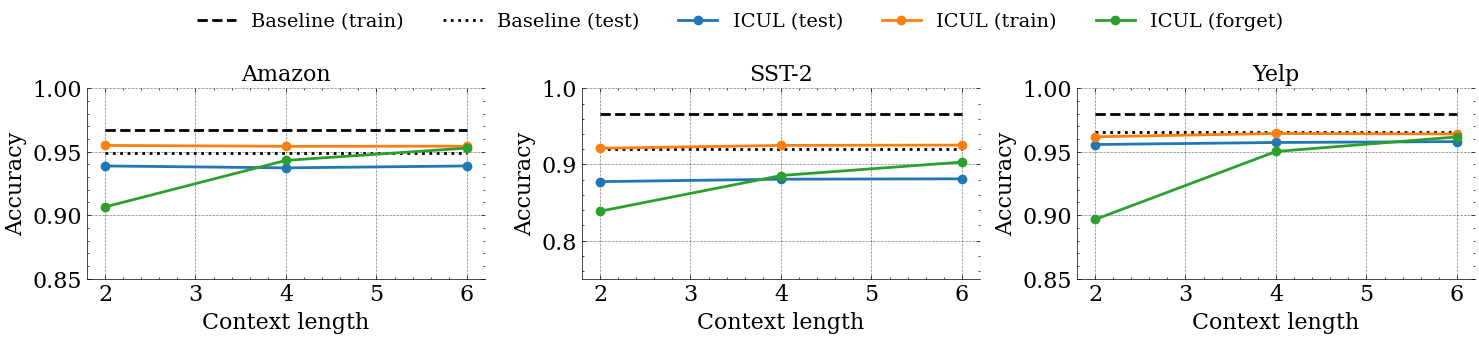

In [42]:
ubs = 1
model_name = 'bloom-1b1'
context_style = 'vary'
ctxt_lengths = [2, 4, 6]
dataset_names = ['amazon_polarity', 'sst2', 'yelp_polarity']
if model_name == 'bloom-560m':
    titles = [ 'Amazon', 'SST-2', 'Yelp', 'IMDb'] #['Yelp', 'IMDb', 'SST-2', 'Amazon']
else:
    titles = [ 'Amazon', 'SST-2', 'Yelp'] #['Yelp', 'IMDb', 'SST-2', 'Amazon']
context_lenghts = np.linspace(2, 8, 1000)
if False:
    methods = ['icl', 'ga']
else:
    methods = ['icl']
xlims = [(0.85,1), (0.75,1), (0.85,1), (0.925,1)]
fig, axs = plt.subplots(1, len(dataset_names), figsize=(len(dataset_names)*5, 3))

res = get_performance_results(dataset_names, 
                              model_name,
                              ctxt_lengths,
                              indices)

for i, dataset_name in enumerate(dataset_names):
    for t in ['train', 'test']:
        res_forget = res[dataset_name][t]['base']['mean']
        res_forget_std = res[dataset_name][t]['icl']['std']
        print(res_forget)
        interp_acc = np.interp(context_lenghts, ctxt_lengths, res_forget)
        interp_std = np.interp(context_lenghts, ctxt_lengths, res_forget_std)
        acc_upper = np.minimum(interp_acc + interp_std, 1)
        acc_lower = np.maximum(interp_acc - interp_std, 0)
        if t == 'test':
            ls = 'dotted'
        else:
            ls = 'dashed'
        if i == 0:
            axs[i].plot(ctxt_lengths, res_forget, label=f'Baseline ({t})', 
                        color='black', linestyle=ls, linewidth=2)
            #axs[i].fill_between(context_lenghts, acc_lower, acc_upper, alpha=0.2, color='black')
        else:
            axs[i].plot(ctxt_lengths, res_forget, color='black', 
                        linestyle=ls, linewidth=2) 
            #axs[i].fill_between(context_lenghts, acc_lower, acc_upper, alpha=0.2, color='black')
    
    for t in ['test', 'train', 'forget']:
        for m in methods:
            res_forget = res[dataset_name][t][m]['mean']
            res_forget_std = res[dataset_name][t][m]['std']
            interp_acc = np.interp(context_lenghts, ctxt_lengths, res_forget)
            interp_std = np.interp(context_lenghts, ctxt_lengths, res_forget_std)
            acc_upper = np.minimum(interp_acc + interp_std, 1)
            acc_lower = np.maximum(interp_acc - interp_std, 0)
            if i == 0:
                if m == 'icl':
                    label = 'ICUL'
                    marker = 'o'
                else:
                    label = 'GA'
                    marker = 'D'
                axs[i].plot(ctxt_lengths, res_forget, label=f'{label} ({t})', 
                            marker=marker, linewidth=2)
                #axs[i].fill_between(context_lenghts, acc_lower, acc_upper, alpha=0.2)
            else:
                if m == 'icl':
                    marker = 'o'
                else:
                    marker = 'D'
                axs[i].plot(ctxt_lengths, res_forget, marker=marker, linewidth=2)
                #axs[i].fill_between(context_lenghts, acc_lower, acc_upper, alpha=0.2)
    axs[i].set_xlabel('Context length')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title(titles[i])
    axs[i].set_ylim(xlims[i])
    axs[i].spines[['right', 'top']].set_visible(False)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=5, fontsize=14)
plt.tight_layout()
plt.savefig(f'results_ubs1/performance_context_length_{model_name}_ubs{ubs}_{context_style}.{savingtype}')

### Performance as LR varies (GA)

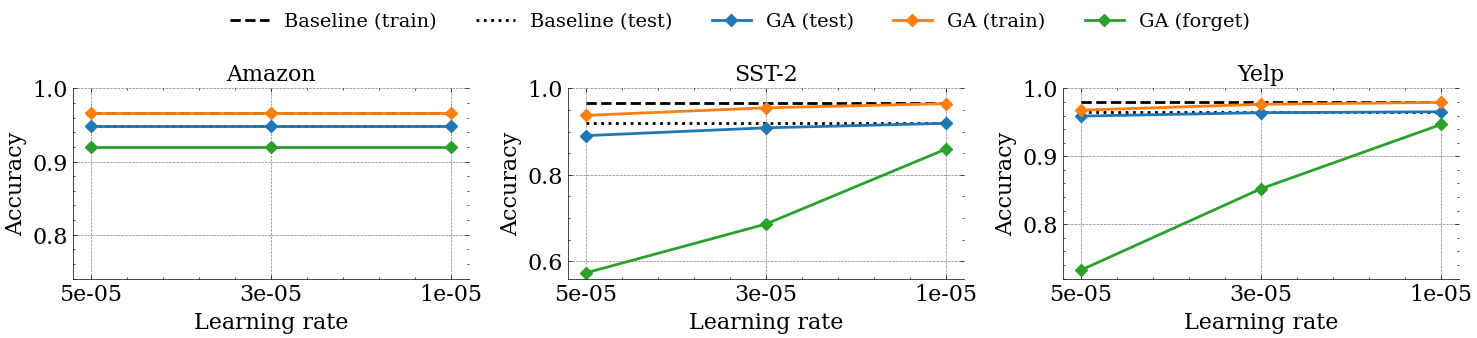

In [43]:
lrs = ['5e-05', '3e-05', '1e-05']
if model_name == 'bloom-560m':
    titles = [ 'Amazon', 'SST-2', 'Yelp', 'IMDb'] #['Yelp', 'IMDb', 'SST-2', 'Amazon']
    xlims = [(0.74,1), (0.56,1), (0.8,1), (0.78, 1)]
else:
    dataset_names = ['amazon_polarity', 'sst2', 'yelp_polarity']
    titles = [ 'Amazon', 'SST-2', 'Yelp'] #['Yelp', 'IMDb', 'SST-2', 'Amazon']
    xlims = [(0.74,1), (0.56,1), (0.72,1)]
context_lenghts = np.linspace(2, 8, 1000)
if False:
    methods = ['icl', 'ga']
else:
    methods = ['ga']
fig, axs = plt.subplots(1, len(dataset_names), figsize=(len(dataset_names)*5, 3))
for i, dataset_name in enumerate(dataset_names):
    for t in ['train', 'test']:
        res_forget = res[dataset_name][t]['base']['mean']
        res_forget_std = res[dataset_name][t]['ga']['std']
        interp_acc = np.interp(context_lenghts, ctxt_lengths, res_forget)
        interp_std = np.interp(context_lenghts, ctxt_lengths, res_forget_std)
        acc_upper = np.minimum(interp_acc + interp_std, 1)
        acc_lower = np.maximum(interp_acc - interp_std, 0)
        if t == 'test':
            ls = 'dotted'
        else:
            ls = 'dashed'
        if i == 0:
            axs[i].plot(lrs, res_forget, label=f'Baseline ({t})', 
                        color='black', linestyle=ls, linewidth=2)
            #axs[i].fill_between(context_lenghts, acc_lower, acc_upper, alpha=0.2, color='black')
        else:
            axs[i].plot(lrs, res_forget, color='black', 
                        linestyle=ls, linewidth=2) 
            #axs[i].fill_between(context_lenghts, acc_lower, acc_upper, alpha=0.2, color='black')
    
    for t in ['test', 'train', 'forget']:
        for m in methods:
            res_forget = res[dataset_name][t][m]['mean']
            res_forget_std = res[dataset_name][t][m]['std']
            interp_acc = np.interp(context_lenghts, ctxt_lengths, res_forget)
            interp_std = np.interp(context_lenghts, ctxt_lengths, res_forget_std)
            acc_upper = np.minimum(interp_acc + interp_std, 1)
            acc_lower = np.maximum(interp_acc - interp_std, 0)
            if i == 0:
                if m == 'icl':
                    label = 'ICUL'
                    marker = 'o'
                else:
                    label = 'GA'
                    marker = 'D'
                axs[i].plot(lrs, res_forget, label=f'{label} ({t})', 
                            marker=marker, linewidth=2)
                #axs[i].fill_between(context_lenghts, acc_lower, acc_upper, alpha=0.2)
            else:
                if m == 'icl':
                    marker = 'o'
                else:
                    marker = 'D'
                axs[i].plot(lrs, res_forget, marker=marker, linewidth=2)
                #axs[i].fill_between(context_lenghts, acc_lower, acc_upper, alpha=0.2)
    axs[i].set_xlabel('Learning rate')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title(titles[i])
    axs[i].set_ylim(xlims[i])
    axs[i].spines[['right', 'top']].set_visible(False)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=5, fontsize=14)
plt.tight_layout()
plt.savefig(f'results_ubs1/performance_lr_{model_name}_ubs{ubs}_{context_style}.{savingtype}')

In [ ]:
### Performance for ablation studies

In [ ]:
standard = get_performance_results(['sst2'], 
                                    model_name='bloom-560m',
                                    ctxt_lengths=[2, 4, 6],
                                    indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                    lr='1e-05', 
                                    regime='lfmfirst-k', 
                                    context_style='vary',
                                    ubs=1, n=12500, GA_FLAG=False)

In [ ]:
'''
rep = get_performance_results(['sst2'], 
                                    model_name='bloom-560m',
                                    ctxt_lengths=[4, 6],
                                    indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                    lr='1e-05', 
                                    regime='lfmfirst-k', 
                                    context_style='ablation-rep',
                                    ubs=1, n=12500, GA_FLAG=False)
'''

In [ ]:
correct = get_performance_results(['sst2'], 
                                    model_name='bloom-1b1',
                                    ctxt_lengths=[2, 4, 6],
                                    indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                    lr='1e-05', 
                                    regime='lfmfirst-k', 
                                    context_style='ablation-correct',
                                    ubs=1, n=12500, GA_FLAG=False)

In [ ]:
exchange = get_performance_results(['sst2'], 
                                    model_name='bloom-1b1',
                                    ctxt_lengths=[2, 4, 6],
                                    indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                    lr='1e-05', 
                                    regime='lfmfirst-k', 
                                    context_style='ablation-exchange',
                                    ubs=1, n=12500, GA_FLAG=False)

In [ ]:
regime = 'test'

#plt.plot([4, 6], rep['yelp_polarity'][regime]['icl']['mean'], marker='x', label='Repeat')
plt.plot([2, 4, 6], standard['sst2'][regime]['base']['mean'], marker='x', label='Baseline', color='k')
plt.plot([2, 4, 6], standard['sst2'][regime]['icl']['mean'], marker='o', label='ICUL')
plt.plot([2, 4, 6], correct['sst2'][regime]['icl']['mean'], marker='d', label='ICL')
plt.plot([2, 4, 6], exchange['sst2'][regime]['icl']['mean'], marker='D', label='ICUL (random)')
plt.legend()
plt.ylim([0.82,1])
plt.title('SST-2 - Bloom1b1')
plt.xlabel('Context Length')
plt.ylabel('Test accuracy')
plt.tight_layout()